In [ ]:
import pandas as pd
import networkx as nx
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pickle
import joblib
import spacy
from sympy import symbols, Implies
import faiss
import torch
from langchain_ollama import OllamaLLM
from tqdm import tqdm
import time
import evaluate
import psutil
from collections import Counter
from rouge_score import rouge_scorer
from bert_score import score as bert_score

In [3]:
# Load data
qa_df = pd.read_csv("../data/processed/Questions & Answers.csv")

In [4]:
# Load the chunked legal cases dataset
chunked_cases_df = pd.read_csv("chunked_law_cases.csv")

### Multi-Hop Context via Semantic Search

In [7]:
# Load a pre-trained embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [8]:
# Compute embeddings for all chunk texts
chunked_cases_df['embedding'] = chunked_cases_df['text'].apply(lambda x: embedding_model.encode(x, convert_to_tensor=False))

### Function to Retrieve Top-5 Relevant Chunks

In [9]:
def get_relevant_chunks(question, chunk_df, model, top_k=5):
    question_emb = model.encode(question, convert_to_tensor=False)
    chunk_embeddings = np.stack(chunk_df['embedding'].to_numpy())
    
    similarities = cosine_similarity([question_emb], chunk_embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    
    return "\n\n".join(chunk_df.iloc[top_indices]['text'].values)

In [10]:
qa_df['prompt'] = qa_df['question'].apply(
    lambda q: f"Context:\n{get_relevant_chunks(q, chunked_cases_df, embedding_model)}\n\nQuestion:\n{q}\n\nAnswer:"
)

In [11]:
# Instantiate the LLaMA model
llm = OllamaLLM(model="llama3.1")

In [12]:
results = []

In [13]:
for idx, row in qa_df.iterrows():
    prompt = row['prompt']
    true_answer = row['answer']

    # Monitor CPU usage before
    cpu_before = psutil.cpu_percent(interval=None)

    # Measure response time
    start_time = time.time()
    try:
        generated_answer = llm(prompt)
    except Exception as e:
        generated_answer = f"ERROR: {e}"
    end_time = time.time()
    response_time = end_time - start_time

    # Monitor CPU usage after (sampling)
    cpu_after = psutil.cpu_percent(interval=None)
    avg_cpu_usage = (cpu_before + cpu_after) / 2

    # Store results
    results.append({
        "question": row['question'],
        "true_answer": true_answer,
        "generated_answer": generated_answer,
        "response_time_sec": response_time,
        "cpu_usage_percent": avg_cpu_usage
    })

C:\Users\User\AppData\Local\Temp\ipykernel_1480\408248792.py:11: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  generated_answer = llm(prompt)


In [14]:
results_df = pd.DataFrame(results)

### Evaluate Responses

In [16]:
def fuzzy_accuracy(pred, truth, threshold=0.8):
    return SequenceMatcher(None, pred.lower(), truth.lower()).ratio() >= threshold

results_df['is_accurate'] = results_df.apply(
    lambda row: fuzzy_accuracy(row['generated_answer'], row['true_answer']), axis=1
)
accuracy = results_df['is_accurate'].mean()
print(f"Fuzzy Accuracy: {accuracy:.2%}")

Fuzzy Accuracy: 0.00%


In [17]:
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def get_rouge_score(pred, truth):
    return rouge.score(truth, pred)['rougeL'].fmeasure

results_df['rougeL'] = results_df.apply(
    lambda row: get_rouge_score(row['generated_answer'], row['true_answer']), axis=1
)

avg_rouge = results_df['rougeL'].mean()
print(f"Average ROUGE-L: {avg_rouge:.4f}")

Average ROUGE-L: 0.2073


In [30]:
P, R, F1 = bert_score(
    results_df['generated_answer'].tolist(),
    results_df['true_answer'].tolist(),
    lang='en',
    verbose=True
)

results_df['bertscore'] = F1.numpy()
avg_bertscore = results_df['bertscore'].mean()
print(f"Average BERTScore F1: {avg_bertscore:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 15.55 seconds, 0.26 sentences/sec
Average BERTScore F1: 0.8511


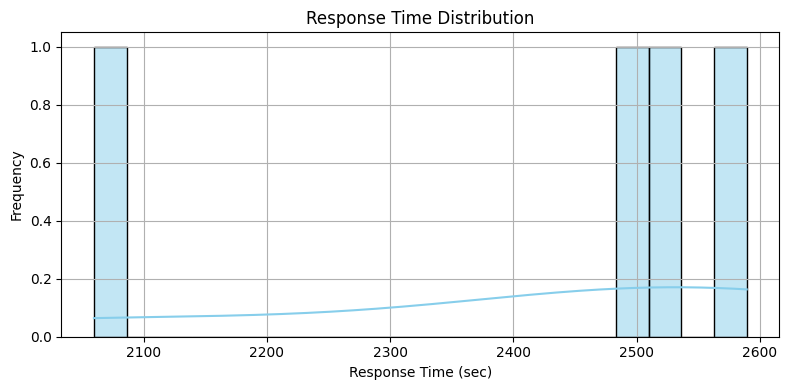

In [31]:
plt.figure(figsize=(8, 4))
sns.histplot(results_df['response_time_sec'], bins=20, kde=True, color='skyblue')
plt.title("Response Time Distribution")
plt.xlabel("Response Time (sec)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

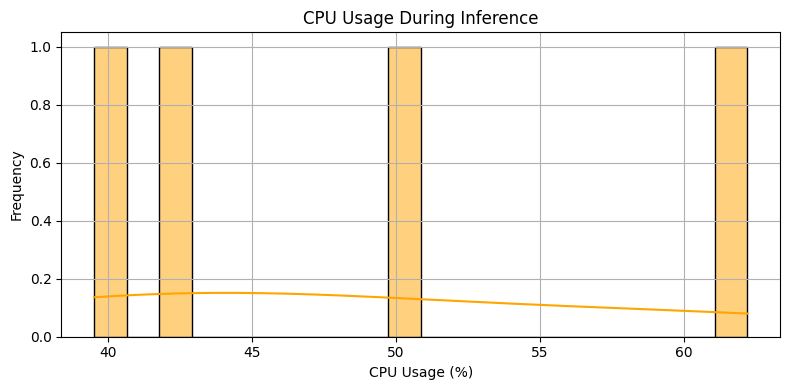

In [32]:
plt.figure(figsize=(8, 4))
sns.histplot(results_df['cpu_usage_percent'], bins=20, kde=True, color='orange')
plt.title("CPU Usage During Inference")
plt.xlabel("CPU Usage (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_1480\932128944.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(avg_scores.keys()), y=list(avg_scores.values()), palette='muted')


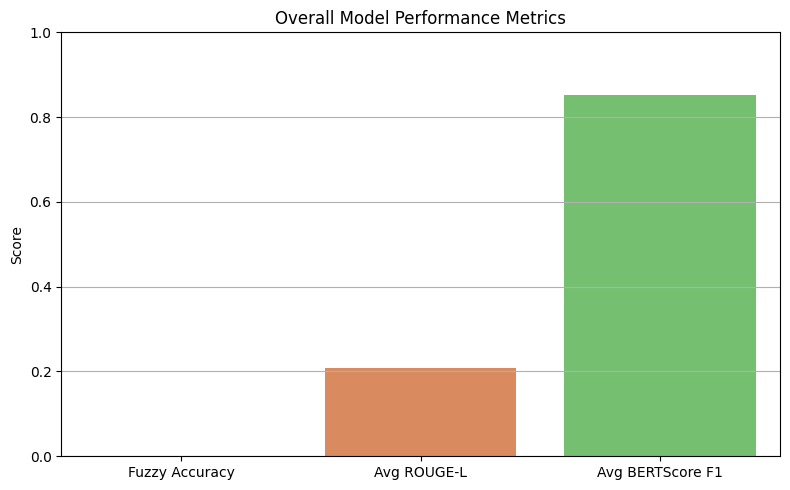

In [33]:
avg_scores = {
    "Fuzzy Accuracy": results_df['is_accurate'].mean(),
    "Avg ROUGE-L": results_df['rougeL'].mean(),
    "Avg BERTScore F1": results_df['bertscore'].mean()
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(avg_scores.keys()), y=list(avg_scores.values()), palette='muted')
plt.ylim(0, 1)
plt.title("Overall Model Performance Metrics")
plt.ylabel("Score")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

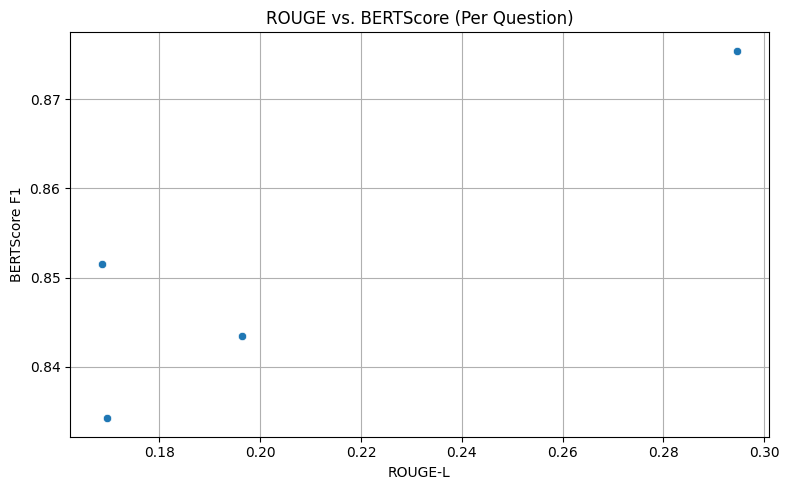

In [34]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='rougeL', y='bertscore', data=results_df)
plt.title("ROUGE vs. BERTScore (Per Question)")
plt.xlabel("ROUGE-L")
plt.ylabel("BERTScore F1")
plt.grid(True)
plt.tight_layout()
plt.show()